# Simplex Algorithm

## Introduction

> “The simplex method is a method for solving problems in linear programming. This method, invented by George Dantzig in 1947, tests adjacent vertices of the feasible set (which is a polytope) in sequence so that at each new vertex the objective function improves or is unchanged.” (Wolfram MathWorld)

The underlying observation is that our linear program bears some resemblance with a linear equation system:

$\mathbf{x} \leq \mathbf{b} \leftrightarrow \mathbf{x} +  \mathbf{s} =  \mathbf{b} \text{ with }  \mathbf{s} \geq 0$

If there are n+m variables in a system of m equations (where n>m),
by setting n variables to zero we can use the remaining m variables and solve the equations.

### Basic Solution
For LP problems in normal form with 𝑚 linear inequalities with 𝑛 variables a basic solution is obtained by setting any 𝑛  of the 𝑛+𝑚 variables to zero and solving for the remaining 𝑚 variables
the 𝑚 non-zero variables are called _basic variables_ the remaining 𝑛 zero-valued variables are called _non-basic variables_.

**In our toy factory example:**
Heuristic solution: 40 soldiers, 20 trains, 20 units of carpenting leftover (0 leftover finishing, 0 leftover production allowance for soldiers)

Other variants:
No leftover carpenting, no leftover finishing

No leftover carpenting, no leftover allowance

Produce nothing

produce no soldiers with no carpenting left

produce no soldiers with no finishing left

produce no soldiers with no maxsoldiers left
produce no trains with no finishing left
produce no trains with no carpenting left
produce no trains with no maxsoldiers left …



In [3]:
def simplex(c, A, b):
    tableau = to_tableau(c, A, b)

    while can_be_improved(tableau):
        pivot_position = get_pivot_position(tableau)
        tableau = pivot_step(tableau, pivot_position)

    return get_solution(tableau)

In [4]:
def to_tableau(c, A, b):
    xb = [eq + [x] for eq, x in zip(A, b)]
    z = c + [0]
    return xb + [z]

In [5]:
def can_be_improved(tableau):
    z = tableau[-1]
    return any(x > 0 for x in z[:-1])
    restrictions = []
    for eq in tableau[:-1]:
        el = eq[column]
        restrictions.append(math.inf if el <= 0 else eq[-1] / el)

    row = restrictions.index(min(restrictions))
    return row, column


In [6]:
import math

def get_pivot_position(tableau):
    z = tableau[-1]
    column = next(i for i, x in enumerate(z[:-1]) if x > 0)
    
    restrictions = []
    for eq in tableau[:-1]:
        el = eq[column]
        restrictions.append(math.inf if el <= 0 else eq[-1] / el)

    row = restrictions.index(min(restrictions))
    return row, column


In [7]:
import numpy as np

def pivot_step(tableau, pivot_position):
    new_tableau = [[] for eq in tableau]
    
    i, j = pivot_position
    pivot_value = tableau[i][j]
    new_tableau[i] = np.array(tableau[i]) / pivot_value
    
    for eq_i, eq in enumerate(tableau):
        if eq_i != i:
            multiplier = np.array(new_tableau[i]) * tableau[eq_i][j]
            new_tableau[eq_i] = np.array(tableau[eq_i]) - multiplier
   
    return new_tableau


In [8]:
def is_basic(column):
    return sum(column) == 1 and len([c for c in column if c == 0]) == len(column) - 1

def get_solution(tableau):
    columns = np.array(tableau).T
    solutions = []
    for column in columns[:-1]:
        solution = 0
        if is_basic(column):
            one_index = column.tolist().index(1)
            solution = columns[-1][one_index]
        solutions.append(solution)
        
    return solutions


In [9]:
c = [3,2,0,0,0]
A = [
    [1, 1,1,0,0],
    [ 2, 1,0,1,0],
    [ 1,0,0,0,1]
]
b = [80,100,40]


In [10]:
solution = simplex(c, A, b)
print('solution: ', solution)

solution:  [20.0, 60.0, 0, 0, 20.0]


In [56]:
def get_objective_function_value(tableau):
    return -tableau[-1][-1]

In [77]:
def simplex_with_visualization(c, A, b, halfspaces, feasible_point):
    tableau = to_tableau(c, A, b)

    zs = [get_objective_function_value(tableau)]
    solutions = [get_solution(tableau)]
    while can_be_improved(tableau):
        pivot_position = get_pivot_position(tableau)
        tableau = pivot_step(tableau, pivot_position)
        solutions.append(get_solution(tableau))
        zs.append(get_objective_function_value(tableau))
    
    points = [v[:2] for v in solutions]
    xlim = (-1, 2*max([p[0] for p in points]) + 1)
    ylim = (-1, 2*max([p[1] for p in points]) + 1)
    render_inequalities(halfspaces, feasible_point, xlim, ylim)

    for start, end in zip(points[:-1], points[1:]):
        dx = end[0] - start[0]
        dy = end[1] - start[1]
        if dx >= 0 and dy >= 0:
            plt.arrow(
                start[0],
                start[1],
                dx,
                dy,
                width=0.1,
                length_includes_head=True,
                color='#1abc9c'
            )
    plt.show()
    
    steps = range(len(zs))
    plt.plot(steps, zs, color="#2c3e50")
    plt.xticks(steps)
    plt.xlabel('iterations')
    plt.ylabel('objective function value')
    
    print(solutions)
    
    return get_solution(tableau)


In [72]:
from scipy.spatial import HalfspaceIntersection, ConvexHull
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import numpy as np

def render_inequalities(halfspaces, feasible_point, xlim, ylim):
    hs = HalfspaceIntersection(np.array(halfspaces), np.array(feasible_point))
    fig = plt.figure()
    ax = fig.add_subplot('111', aspect='equal')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    x = np.linspace(*xlim, 40)

    for h in halfspaces:
        if h[1]== 0:
            ax.axvline(-h[2]/h[0], color="#2c3e50")
        else:
            ax.plot(x, (-h[2]-h[0]*x)/h[1], color="#2c3e50")
    x, y = zip(*hs.intersections)
    points = list(zip(x, y))
    convex_hull = ConvexHull(points)
    polygon = Polygon([points[v] for v in convex_hull.vertices], color="#34495e")
    ax.add_patch(polygon)
    ax.plot(x, y, 'o', color="#e67e22")

<ipython-input-72-6c816303c502>:9: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot('111', aspect='equal')


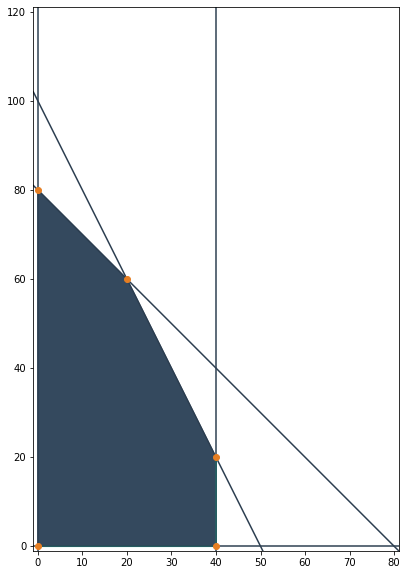

[[0, 0, 80, 100, 40], [40.0, 0, 40.0, 20.0, 0], [40.0, 20.0, 20.0, 0, 0], [20.0, 60.0, 0, 0, 20.0]]


[20.0, 60.0, 0, 0, 20.0]

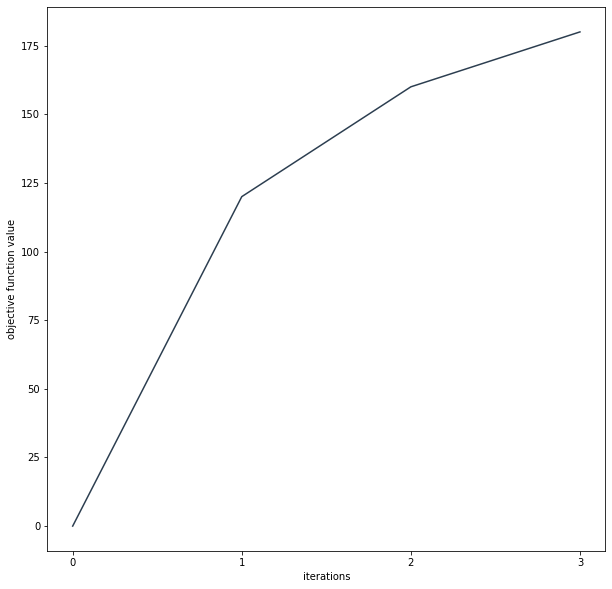

In [78]:
plt.rcParams["figure.figsize"] = (10,10)

halfspaces = [
    [-1, 0., 0.],    # x₁ ≥ 0
    [0., -1., 0.],   # x₂ ≥ 0
    [1, 1, -80.], # 4x₂ - x₁ ≤ 13
    [2., 1., -100.],   # x₂ + 2x₁ ≤ 10
    [1., 0., -40.]   # x₂ + 2x₁ ≤ 10
]

feasible_point = [0.5, 0.5]

xlim = (-1, 100)
ylim = (-1, 100)

simplex_with_visualization(c,A,b,halfspaces, feasible_point)

<ipython-input-61-6c816303c502>:9: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot('111', aspect='equal')


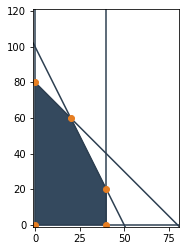

[20.0, 60.0, 0, 0, 20.0]

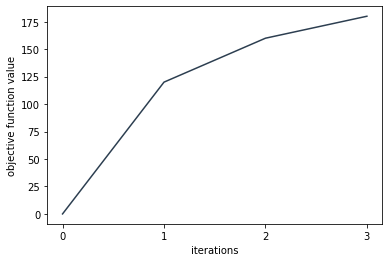

In [63]:
halfspaces = [
    [-1, 0., 0.],    # x₁ ≥ 0
    [0., -1., 0.],   # x₂ ≥ 0
    [1, 1, -80.], # 4x₂ - x₁ ≤ 13
    [2., 1., -100.],   # x₂ + 2x₁ ≤ 10
    [1., 0., -40.]   # x₂ + 2x₁ ≤ 10
]

feasible_point = [0.5, 0.5]

xlim = (-1, 100)
ylim = (-1, 100)


simplex_with_visualization(c,A,b,halfspaces, feasible_point)